# Predict Bike Sharing Demand with AutoGluon (cont.)

# Notes:
I ran the notebook in Google Colab so I need to install packages again each time. The notebook is meant to complement the main one, addressing the things that I have not implemented. The first steps will be relatively the same.

In [1]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = ""
kaggle_key = ""

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [4]:
%%capture
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

In [5]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 74.7MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [8]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.loc[:,'season':'weather'] = train.loc[:,'season':'weather'].astype('category')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  category      
 3   workingday  10886 non-null  category      
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(3), int64(4)
memory usage: 723.7 KB


In [10]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [11]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv')
test.loc[:,'datetime'] = pd.to_datetime(test.loc[:,'datetime'])
test.loc[:,'season':'weather'] = test.loc[:,'season':'weather'].astype('category')
test.head()

<ipython-input-11-3333bdc5bf54>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[:,'datetime'] = pd.to_datetime(test.loc[:,'datetime'])


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   category      
 2   holiday     6493 non-null   category      
 3   workingday  6493 non-null   category      
 4   weather     6493 non-null   category      
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: category(4), datetime64[ns](1), float64(3), int64(1)
memory usage: 279.8 KB


In [13]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [14]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  6493 non-null   datetime64[ns]
 1   count     6493 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 101.6 KB


In [17]:
# create a new feature
train['hour'] = train.datetime.dt.hour
test['hour'] = test.datetime.dt.hour

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [15]:
xgb_options = {'booster':'dart', 'eta':'0.1'}
rf_options = {'n_estimators':200}

time_limit = 900
num_trials = 5
search_strategy = 'auto'

hyperparameter_tune_kwargs = {
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

In [18]:
predictor = TabularPredictor(label='count',
                             problem_type='regression',
                             eval_metric='root_mean_squared_error',
                             learner_kwargs = {'ignored_columns': ['casual', 'registered']}
                             ).fit(train_data=train,
                                   time_limit=600,
                                   hyperparameters={'XGB': xgb_options,
                                                    'RF': rf_options},
                                   hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                   presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20230529_100130/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230529_100130/"
AutoGluon Version:  0.7.0
Python Version:     3.10.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11713.5 MB
	Train Data (Original)  Memory Usage: 0.57 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the feature

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	-41.3214	 = Validation score   (-root_mean_squared_error)
	169.67s	 = Training   runtime
	0.0s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 422.93s of remaining time.
	-37.3166	 = Validation score   (-root_mean_squared_error)
	0.29s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 2 L2 models ...
Hyperparameter tuning model: RandomForest_BAG_L2 ... Tuning model for up to 190.17s of the 422.59s of remaining time.
	No hyperparameter search space specified for RandomForest_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: RandomForest_BAG_L2 ...
	-37.9708	 = Validation score   (-root_mean_squared_error)
	17.81s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tunin

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L2/T1 ...
	-37.2291	 = Validation score   (-root_mean_squared_error)
	162.3s	 = Training   runtime
	0.0s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 242.33s of remaining time.
	-37.0635	 = Validation score   (-root_mean_squared_error)
	0.15s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 357.85s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230529_100130/")


In [19]:
predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L3 -37.063491       0.012429  357.022567                0.000674           0.150200            3       True          6
1    XGBoost_BAG_L2/T1 -37.229063       0.011516  339.061054                0.000124         162.295944            2       True          5
2  WeightedEnsemble_L2 -37.316590       0.015952  177.058399                0.004560           0.293289            2       True          3
3  RandomForest_BAG_L2 -37.970848       0.011631  194.576422                0.000239          17.811313            2       True          4
4  RandomForest_BAG_L1 -38.559736       0.011225    7.091160                0.011225           7.091160            1       True          1
5    XGBoost_BAG_L1/T1 -41.321412       0.000167  169.673949                0.000167         169.673949 

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForest_BAG_L2': 'StackerEnsembleModel_RF',
  'XGBoost_BAG_L2/T1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'RandomForest_BAG_L1': -38.55973590917933,
  'XGBoost_BAG_L1/T1': -41.321411554615295,
  'WeightedEnsemble_L2': -37.31658982258544,
  'RandomForest_BAG_L2': -37.97084772569969,
  'XGBoost_BAG_L2/T1': -37.22906323655433,
  'WeightedEnsemble_L3': -37.06349085462143},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'RandomForest_BAG_L1': 'AutogluonModels/ag-20230529_100130/models/RandomForest_BAG_L1/',
  'XGBoost_BAG_L1/T1': '/content/AutogluonModels/ag-20230529_100130/models/XGBoost_BAG_L1/T1/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20230529_100130/models/WeightedEnsemble_L2/',
  'RandomForest_BAG_L2': 'AutogluonModels/ag-20230

<Axes: xlabel='model'>

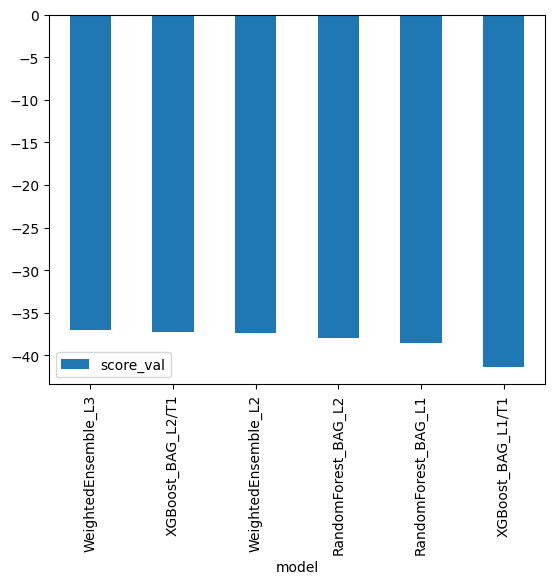

In [20]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

### Create predictions from test dataset

In [21]:
predictions = predictor.predict(test)
predictions.head()

0    11.740690
1     5.859677
2     3.744877
3     3.270157
4     3.282072
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [22]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      191.836212
std       173.315659
min         2.832216
25%        47.614754
50%       150.358307
75%       282.785278
max       886.419189
Name: count, dtype: float64

In [23]:
# How many negative values do we have?
predictions.lt(0).sum()

0

In [24]:
# Set them to zero
predictions[predictions.lt(0)] = 0
predictions.head()

0    11.740690
1     5.859677
2     3.744877
3     3.270157
4     3.282072
Name: count, dtype: float32

In [25]:
predictions.lt(0).sum()

0

### Set predictions to submission dataframe, save, and submit

In [26]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [27]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "added hyperparameters submission"

100% 188k/188k [00:00<00:00, 333kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [29]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                             status    publicScore  privateScore  
---------------------------  -------------------  --------------------------------------  --------  -----------  ------------  
submission.csv               2023-05-29 10:07:32  added hyperparameters submission        complete  0.45699      0.45699       
submission.csv               2023-05-27 02:17:27  gradient boosting with GridSearchCV     complete  0.38863      0.38863       
submission_new_hpo_1.csv     2023-05-26 08:41:56  new features with increased time limit  complete  0.67834      0.67834       
submission_new_hpo.csv       2023-05-26 08:19:14  new features with hyperparameters       complete  0.61537      0.61537       


#### A score of $0.45699$